In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

## Markov chain
One natural method of modelling this scenario is with a Markov chain. The way a Markov chain works is by describing a system with a number of states, and describing the probability of moving from state to state. 


### States
In this scenario, the number of people wanting to or currently using the bathroom will define each state. So state 0 means that no one is using the bathroom, and state 2 means 2 people are wanting to use the bathroom, maybe one person is using the only bathroom and one person is waiting, or maybe there are two bathrooms and are both being used, or even there are 3 bathrooms and one is still free. How can we deal with this distinction?

Let's define $n$ as the number of people in the household, $k$ define the number of bathrooms available. This scenario is only interesting if there are less bathrooms than people, giving rise to the possibility that someone cannot use the bathroom if they wanted to because they are all full. So let's assume $n > k$.

Since there are $n$ people, there will be $n + 1$ states: $0, 1, \cdots , n$

In [2]:
n = 4 # Number of people
k = 2 # Number of bathrooms

### Moving between states
Now that we've defined the states, we need to define a [transition rate matrix](https://en.wikipedia.org/wiki/Transition_rate_matrix), $Q$. The element $q_{i, j}$ represents the transition rate of moving from state $i$ to $j$. Note that indexing starts at 0, so $q_{0, 0}$ is the topleft element in the Q matrix.

Suppose there are 5 people living in the house and 2 people already in the bathroom, there are 3 other people that have the potential to need to go too. So the transition rate to the higher state is simply $ 3 \lambda $. Since there are 2 in the bathroom, both with the potential to come out, the transition rate to the lower state is $ 2 \mu $.

This can be generalised as:
$$ q_{i, i+1} = (n-i)\,\lambda \qquad \text{ for } i < n $$
$$ q_{i, i-1} = \min(k, i)\,\mu \qquad \text{ for } i > 0 $$
$$ q_{i, j} = 0 \qquad \text{for all other} \: i \neq j $$

Note that the $\min(k, i)$ is to cap the transition rate to the lower level. We're assuming people won't suddenly decide they don't need to go without having been!

### Setting constants
The normal number of times someone goes to the toilet is [6 to 7 times per day](https://www.bladderandbowel.org/bladder/bladder-conditions-and-symptoms/frequency/). Of course, most people are asleep [7 to 8 hours a day](https://www.medscape.org/viewarticle/511229). So approximate the rate as 6 times every 17 hours.

On average, [one hour and 42 minutes](https://www.scotsman.com/news/how-long-do-we-spend-in-bathroom-1-189-years-1-1072528) is spent going to the toilet each week, and another one hour and 25 minutes in the shower. In other words, 187 minutes per week, roughly 4 and a half minutes per visit.

In [3]:
trips_per_day = 6.5
# Rate of going into bathroom, underscore as lambda is Python keyword 17/24 represents the hours we are awake
lambda_ = trips_per_day / 24.0 / 60.0 / (17/24.0) 

avg_minutes_spent = 4.5
mu = 1/avg_minutes_spent # Rate of leaving

In [4]:
Q = np.zeros((n + 1, n + 1))
for i in range(n + 1):
    if i < n:
        Q[i][i+1] = (n-i) * lambda_
    if i > 0:
        Q[i][i-1] = min(k, i) * mu
    
    Q[i][i] = - sum(Q[i, :])
Q

array([[-0.0254902 ,  0.0254902 ,  0.        ,  0.        ,  0.        ],
       [ 0.22222222, -0.24133987,  0.01911765,  0.        ,  0.        ],
       [ 0.        ,  0.44444444, -0.45718954,  0.0127451 ,  0.        ],
       [ 0.        ,  0.        ,  0.44444444, -0.45081699,  0.00637255],
       [ 0.        ,  0.        ,  0.        ,  0.44444444, -0.44444444]])

### Finding the long run probabilities
Given the system is defined as it is, what is the asymptotic proportion of time the system is spent in each state?

Let $\pi_i$ represent the proportion of time the system is spend in state $i$. Because these are proportions, we need the values to satisfy $\sum_i \pi_i = 1 $.

How can we work out what these proportions are? Since we want to look at proportions as time goes to infinity, we are really trying to find an equilibrium in the system. In an equilibrium, everything balances perfectly, and in this context, balance can be represented as:
$$ \pi_i  \times -q_{i, i} = \sum_{i \neq j} \pi_j \times q_{j, i} $$
On the left hand side, we have the rate of transition OUT of state i as time goes to infinity. On the right, we have the rate of transition INTO state i as time goes to infinity. Equating these imply we have reached a sort of equilibrium.

Another way of writing this is
$$ 0 = \pi_i  \times q_{i, i} + \sum_{i \neq j} \pi_j \times q_{j, i} \qquad \text{for all i}$$
Now let's define the vector *$\vec{\pi} = (\pi_0, ..., \pi_n)$*

Another way to write the above equations is now:
$$\vec{0} = \vec{\pi}Q$$

This is a [homogeneous system](https://en.wikipedia.org/wiki/System_of_linear_equations#Homogeneous_systems), meaning that $\vec{\pi} = \vec{0}$ is always a solution. Obviously, this is not useful, and we need another constraint:
$$\vec{\pi} \cdot \vec{1} = 1 $$

To represent this all in matrix form, let $R$ represent the matrix $Q$ with an extra column at the end whose elements are all 1. Then:
$$\vec{\pi} R = (0, ..., 0, 1) = \vec{b} $$
Where the RHS is a vector of n+1 0s and one 1, defined as $\vec{b}$.

Let's rearrange this to a more conventional $A\vec{x} = \vec{b}$ format by transposing everything.
$$ A \vec{\pi} = \vec{b} $$
Where $A=R^T$ and $\vec{\pi},\,\vec{b}$ are column vectors.


In [5]:
R = np.c_[Q, np.ones((n+1, 1))]
A = R.T
b = np.append(np.zeros(n+1), 1)
pi, residuals, rank, s = np.linalg.lstsq(A, b)
pi

array([  8.93029815e-01,   1.02435773e-01,   4.40624464e-03,
         1.26355545e-04,   1.81171553e-06])

#### SVD decomposition
Another way to solve for $\vec{\pi}$ is through SVD. Given a matrix, $Q^T$, SVD will decompose it into:
$$ Q^T = U\Sigma V^T$$
THere are more details on [here](https://www.ecse.rpi.edu/~qji/CV/svd_review.pdf), but $\Sigma$ is a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) and we are interested in the element on the diagonal that equals 0.

The columns of $V$ (rows of matrix on the right, $V^T$) represent basis vectors for the null space of $Q$, meaning all solutions to $Q^T \vec{\pi} = \vec{0} $ can be constructed using a linear combination of those columns.

In [6]:
U, S, V_T = np.linalg.svd(Q.T)
np.diag(S.round(2))

array([[ 0.84,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.65,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.39,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.21,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

By convention, the decomposition is reordered so that the non zero entries os $\Sigma$ are in descending order. Now we simply find the basis vectors for the null space.

In [7]:
zero_pos = [i for i, s in enumerate(S) if abs(s) < 1e-10]
basis_vector = V_T.T[:,zero_pos]

Once finding the basis vector, we know that the solution is the basis vector multiplied by some constant. With the only constraint being that the sum of its elements equal to 1. Finding the correct solution is very easy from here; just divide each element by the sum of all the elements.

In [8]:
pi_svd = basis_vector/sum(basis_vector)
print(pi_svd)

assert np.all(abs(pi_svd.flatten() - pi) < 1e-10) == True # Check with previous answer

[[  8.93029815e-01]
 [  1.02435773e-01]
 [  4.40624464e-03]
 [  1.26355545e-04]
 [  1.81171553e-06]]


## Proportion of time
Now we want to find the proportion of time that someone wants to use the bathroom but is unable to. So we want $\sum_{i>k}\pi_i$

In [9]:
sum(pi[k+1:])

0.00012816726046847171

## Compare different combinations
Now that we know how to find the proportion of time, let's compare how this proportion changes as $n$, $k$ change.

First, let's wrap the above calculation into a function.

In [10]:
def prop_not_free(n, k, trips_per_day=6.5, avg_minutes_spent=4.5):
    ''' n people in a house with k bathrooms. 
    lambda_ times each person on average uses the bathroom per minute. 
    mu minutes spent on average in the bathroom per use
    Returns the number of minutes per day expected that someone can't use the bathroom
    '''
    # Rate of going into bathroom, underscore as lambda is Python keyword 17/24 represents the hours we are awake
    lambda_ = trips_per_day / 24.0 / 60.0 / (17/24.0) 

    mu = 1/avg_minutes_spent # Rate of leaving
    
    # Transition matrix
    Q = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        if i < n:
            Q[i][i+1] = (n-i) * lambda_
        if i > 0:
            Q[i][i-1] = min(k, i) * mu

        Q[i][i] = - sum(Q[i, :])
    
    # Method 1 least squares
    R = np.c_[Q, np.ones((n+1, 1))]
    A = R.T
    b = np.append(np.zeros(n+1), 1)
    pi, residuals, rank, s = np.linalg.lstsq(A, b)
    
    # Method 2 SVD
    U, S, V_T = np.linalg.svd(Q.T)
    zero_pos = [i for i, s in enumerate(S) if abs(s) < 1e-10]
    basis_vector = V_T.T[:,zero_pos]
    pi_svd = basis_vector/sum(basis_vector)
    assert np.all(abs(pi_svd.flatten() - pi) < 1e-10) == True # Check with previous answer
    
    prop_cant_use = sum(pi[k+1:])
    min_cant_use_per_day = prop_cant_use * (24 * 60.0)
    return min_cant_use_per_day

### Run calculations

In [11]:
MAX_PEOPLE = 10
MAX_BATHROOM = 4


results = pd.DataFrame(0.0, index=range(MAX_PEOPLE, 1, -1), columns=range(1, MAX_BATHROOM + 1))
results.index.name = 'Num_people'

for num_people in range(2, MAX_PEOPLE + 1):
    for num_bathroom in range(1, min(num_people, MAX_BATHROOM + 1)):
        results[num_bathroom][num_people] = prop_not_free(num_people, num_bathroom)

### Visualise
Using heatmap to visualise

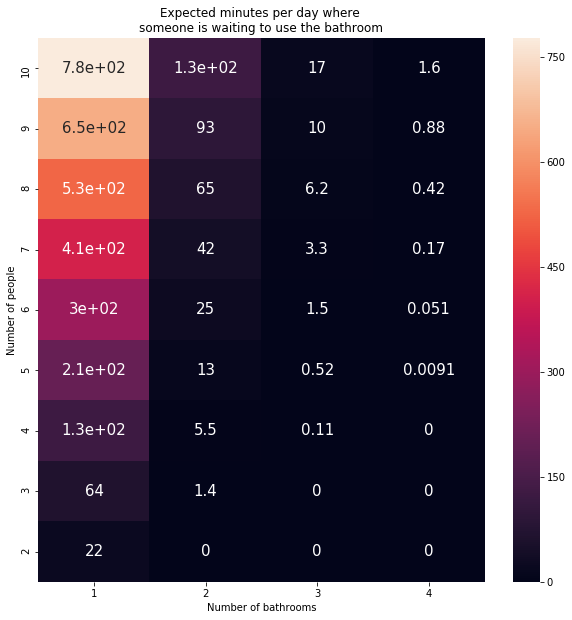

In [14]:
sns.heatmap(results, annot=True, annot_kws={"size": 15})
plt.xlabel('Number of bathrooms')
plt.ylabel('Number of people')
plt.title('Expected minutes per day where \nsomeone is waiting to use the bathroom')
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

As expected, the more people there are, the longer the expected wait time. And the more bathrooms there are, the shorter. What is interesting, however, is how drastically each additional bathroom can reduce the wait time. In fact, having 10 people using 2 bathrooms will clash less than having 3 people use 1! 

I wanted to see whether the effect was still so drastic if we increase the average time spent in the bathroom per visit

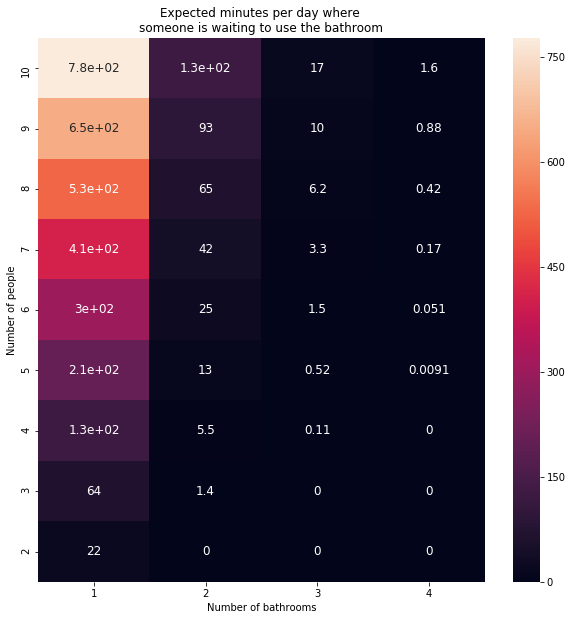

In [13]:
MAX_PEOPLE = 10
MAX_BATHROOM = 4


results = pd.DataFrame(0.0, index=range(MAX_PEOPLE, 1, -1), columns=range(1, MAX_BATHROOM + 1))
results.index.name = 'Num_people'

for num_people in range(2, MAX_PEOPLE + 1):
    for num_bathroom in range(1, min(num_people, MAX_BATHROOM + 1)):
        results[num_bathroom][num_people] = prop_not_free(num_people, num_bathroom, avg_minutes_spent=15)

sns.heatmap(results, annot=True, annot_kws={"size": 12})
plt.xlabel('Number of bathrooms')
plt.ylabel('Number of people')
plt.title('Expected minutes per day where \nsomeone is waiting to use the bathroom')
plt.rcParams["figure.figsize"] = [10, 10]
plt.show()

The effect is still quite drastic, but not as drastic as before. In the scenario where the average bathroom visit is 15 minutes, 3 people sharing 1 is better than 10 people sharing 2. It is not until we get to 7 people sharing 2 where we have a *slight* improvement on 3 people sharing 1.